In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision , Recall
from tensorflow.keras.layers import Dense , ReLU , Embedding , BatchNormalization , Concatenate
from tensorflow.keras.layers import Conv1D , GlobalMaxPooling1D , Dropout , Input
from tensorflow.keras.models import Sequential , Model 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

2025-05-17 23:56:39.867360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747526200.217747      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747526200.316388      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [3]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [5]:
df['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

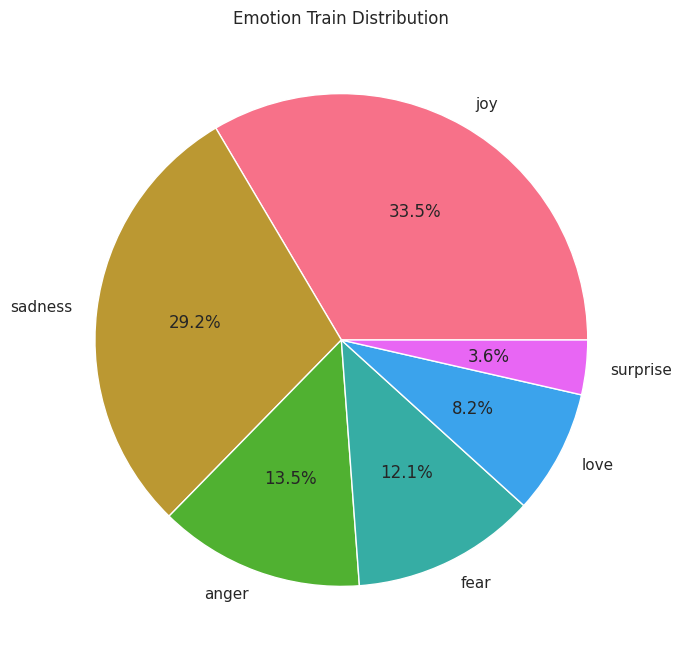

In [6]:
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors = len(label_counts))
sns.set(style='whitegrid')
plt.figure(figsize=(8,8))
plt.pie(label_counts , labels = label_counts.index , autopct = '%1.1f%%' , startangle = 0 , colors = light_colors)
plt.title('Emotion Train Distribution')
plt.show()

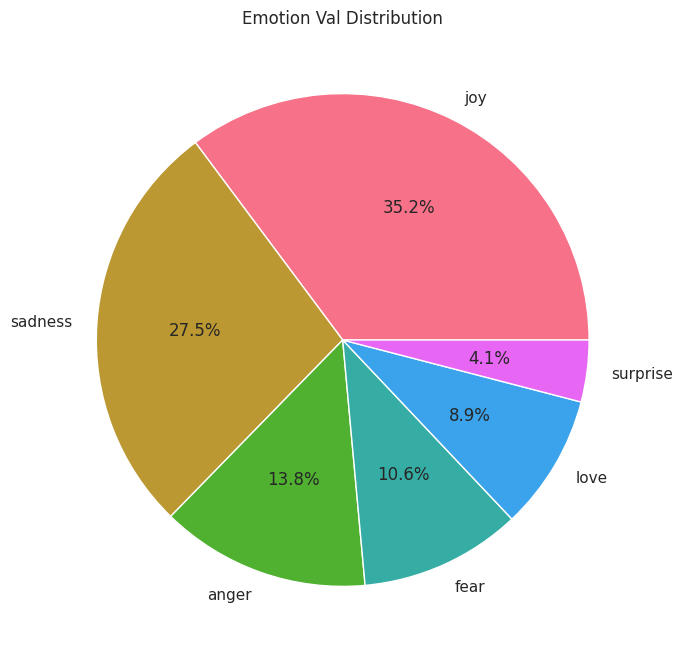

In [7]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors = len(label_counts))
sns.set(style='whitegrid')
plt.figure(figsize=(8,8))
plt.pie(label_counts , labels = label_counts.index , autopct = '%1.1f%%' , startangle = 0 , colors = light_colors)
plt.title('Emotion Val Distribution')
plt.show()

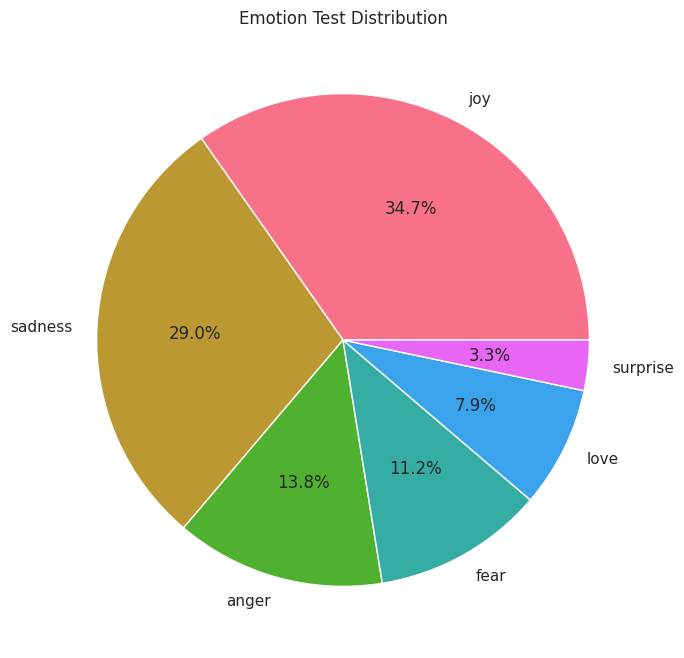

In [8]:
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors = len(label_counts))
sns.set(style='whitegrid')
plt.figure(figsize=(8,8))
plt.pie(label_counts , labels = label_counts.index , autopct = '%1.1f%%' , startangle = 0 , colors = light_colors)
plt.title('Emotion Test Distribution')
plt.show()

In [9]:
df[df['label'] == 'love']

,sentence,label
3,i am ever feeling nostalgic about the fireplac...,love
9,i feel romantic too,love
47,i can t let go of that sad feeling that i want...,love
61,i ate i could feel a gentle tingle throughout ...,love
68,i suppose my own truth needs to be shared i ha...,love
...,...,...
15936,im better than the rest of you feeling but a f...,love
15958,i feel there is going to be a sequel and i wou...,love
15963,i love what i do and i feel so blessed and luc...,love
15971,i feel it would not be loving of me not warn y...,love


In [10]:
df = df.drop(df[df['label'] == 'love'].index )
df = df.drop(df[df['label'] == 'surprise'].index )


In [11]:
df.label.value_counts()

label
joy        5362
sadness    4666
anger      2159
fear       1937
Name: count, dtype: int64

In [12]:
joy = df[df['label'] == 'joy'].sample(n = 2200 ,random_state = 42)
sadness = df[df['label'] == 'sadness'].sample(n = 2200 ,random_state = 42)
anger = df[df['label'] == 'anger'].sample(n = 2159 ,random_state = 42)
fear = df[df['label'] == 'fear'].sample(n = 1937 ,random_state = 42)
df_sampled  = pd.concat([joy , sadness , anger , fear])

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [13]:
df.label.value_counts()

label
joy        2200
sadness    2200
anger      2159
fear       1937
Name: count, dtype: int64

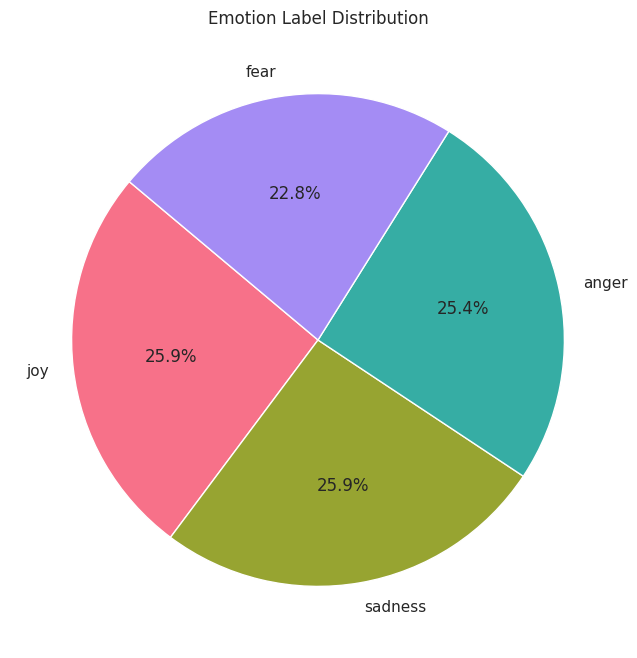

In [14]:
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Label Distribution')
plt.show()

In [15]:
val_df.label.value_counts()

label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [16]:
val_df = val_df.drop(val_df[val_df['label'] == 'love'].index )
val_df = val_df.drop(val_df[val_df['label'] == 'surprise'].index )

In [17]:
val_df.label.value_counts()

label
joy        704
sadness    550
anger      275
fear       212
Name: count, dtype: int64

In [18]:
joy = val_df[val_df['label'] == 'joy'].sample(n = 250 ,random_state = 42)
sadness = val_df[val_df['label'] == 'sadness'].sample(n = 250 ,random_state = 42)
anger = val_df[val_df['label'] == 'anger'].sample(n = 275 ,random_state = 42)
fear = val_df[val_df['label'] == 'fear'].sample(n = 212 ,random_state = 42)
df_sampled  = pd.concat([joy , sadness , anger , fear])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

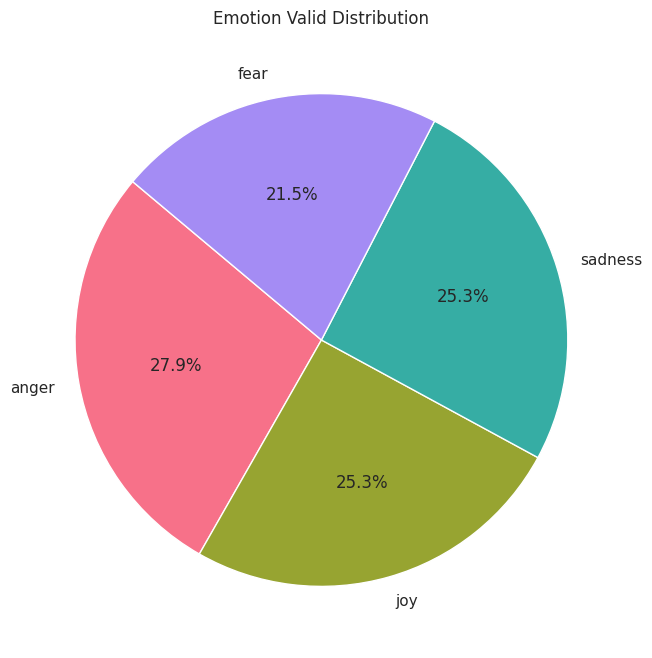

In [19]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Valid Distribution')
plt.show()

In [20]:
ts_df.label.value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [21]:
ts_df = ts_df.drop(ts_df[ts_df['label'] == 'love'].index )
ts_df = ts_df.drop(ts_df[ts_df['label'] == 'surprise'].index )

In [22]:
ts_df.label.value_counts()

label
joy        695
sadness    581
anger      275
fear       224
Name: count, dtype: int64

In [23]:
joy = ts_df[ts_df['label'] == 'joy'].sample(n = 250 ,random_state = 42)
sadness = ts_df[ts_df['label'] == 'sadness'].sample(n = 250 ,random_state = 42)
anger = ts_df[ts_df['label'] == 'anger'].sample(n = 275 ,random_state = 42)
fear = ts_df[ts_df['label'] == 'fear'].sample(n = 212 ,random_state = 42)
df_sampled  = pd.concat([joy , sadness , anger , fear])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

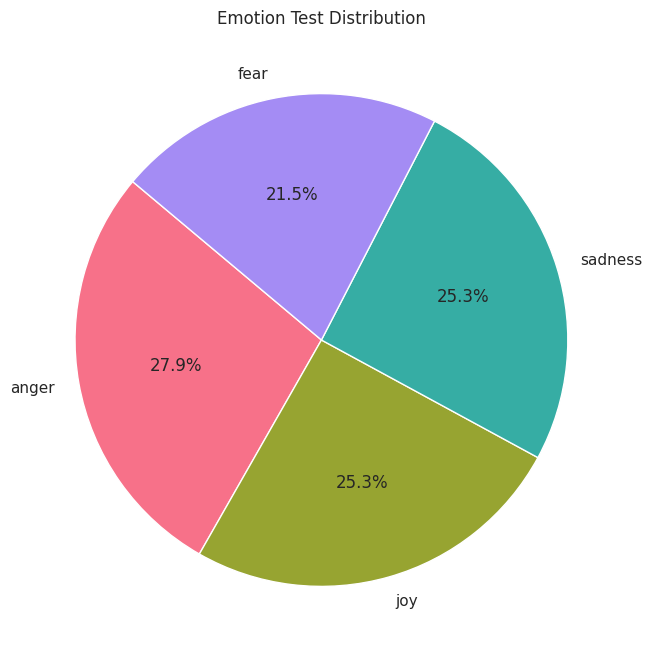

In [24]:
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Test Distribution')
plt.show()

In [25]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

In [26]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [27]:
for i in np.unique(tr_label):
    print(f'{encoder.inverse_transform([i])} : {i}')

['anger'] : 0
['fear'] : 1
['joy'] : 2
['sadness'] : 3


In [28]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

In [29]:
max_words = 10000
max_len = 50
embedding_dim = 32

In [30]:
input_layer = Input(shape=(max_len,))

# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

out1 = branch1(input_layer)
out2 = branch2(input_layer)

concatenated = Concatenate()([out1, out2])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

2025-05-17 23:57:04.260588: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64)             │        326,464 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64)             │        326,464 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            516 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 669,956 (2.56 MB)

 Trainable params: 669,700 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [31]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [32]:
#input_layer = Input(shape=(max_len,))

# Branch 1
#x1 = Embedding(max_words, embedding_dim)(input_layer)
#x1 = Conv1D(64, 3, padding='same', activation='relu')(x1)
#x1 = BatchNormalization()(x1)
#x1 = ReLU()(x1)
#x1 = Dropout(0.5)(x1)
#out1 = GlobalMaxPooling1D()(x1)

# Branch 2
#x2 = Embedding(max_words, embedding_dim)(input_layer)
#x2 = Conv1D(64, 3, padding='same', activation='relu')(x2)
#x2 = BatchNormalization()(x2)
#x2 = ReLU()(x2)
#x2 = Dropout(0.5)(x2)
#out2 = GlobalMaxPooling1D()(x2)

# Concatenate
#concatenated = Concatenate()([out1, out2])

# Dense layers
#hid_layer = Dense(128, activation='relu')(concatenated)
#dropout = Dropout(0.3)(hid_layer)
#output_layer = Dense(4, activation='softmax')(dropout)

# Model
#model = Model(inputs=input_layer, outputs=output_layer)

#model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', Precision(), Recall()])

#model.fit(tr_x, tr_y, epochs=25, batch_size=256, validation_data=(val_x, val_y))


In [33]:
# Branch 1
#branch1 = Sequential()
#branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
#branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
#branch1.add(BatchNormalization())
#branch1.add(ReLU())
#branch1.add(Dropout(0.5))
#branch1.add(GlobalMaxPooling1D())

# Branch 2
#branch2 = Sequential()
#branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
#branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
#branch2.add(BatchNormalization())
#branch2.add(ReLU())
#branch2.add(Dropout(0.5))
#branch2.add(GlobalMaxPooling1D())

#concatenated = Concatenate()([branch1.output, branch2.output])

#hid_layer = Dense(128, activation='relu')(concatenated)
#dropout = Dropout(0.3)(hid_layer)
#output_layer = Dense(4, activation='softmax')(dropout)

#model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [34]:
model.fit(tr_x, tr_y, epochs=30, batch_size=256, validation_data=(val_x, val_y))


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.2536 - loss: 1.8536 - precision: 0.2614 - recall: 0.1405 - val_accuracy: 0.2543 - val_loss: 1.3863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.2892 - loss: 1.4380 - precision: 0.3529 - recall: 0.0419 - val_accuracy: 0.2655 - val_loss: 1.3861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.3228 - loss: 1.3687 - precision: 0.4082 - recall: 0.0208 - val_accuracy: 0.3080 - val_loss: 1.3855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.3622 - loss: 1.3270 - precision: 0.5128 - recall: 0.0285 - val_accuracy: 0.3202 - val_loss: 1.3842 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3873 - loss: 1.2986 - precision: 0.5195 - recall: 0.0487 - val_ac

In [35]:
(loss, accuracy, precision, recall) = model.evaluate(tr_x, tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(precision, 2)}, Recall: {round(recall, 2)}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9964 - loss: 0.0312 - precision: 0.9966 - recall: 0.9955
Loss: 0.03, Accuracy: 1.0, Precision: 1.0, Recall: 0.99


In [36]:
y_true =[]
for i in range(len(ts_y)):
    x = np.argmax(ts_y[i])
    y_true.append(x)

In [37]:
preds = model.predict(ts_x)
y_pred = np.argmax(preds , axis = 1)
y_pred

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([2, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0, 3, 1, 2, 2, 0, 2, 2, 2, 3, 0, 1,
       3, 0, 3, 3, 1, 0, 3, 2, 3, 2, 0, 3, 3, 3, 2, 3, 0, 2, 3, 3, 3, 1,
       0, 0, 0, 0, 1, 1, 2, 0, 2, 3, 1, 0, 0, 0, 3, 3, 0, 0, 0, 1, 3, 2,
       2, 2, 2, 2, 0, 3, 0, 0, 1, 3, 1, 1, 3, 0, 0, 1, 0, 3, 2, 0, 0, 3,
       1, 2, 3, 0, 2, 0, 2, 0, 2, 2, 0, 3, 0, 1, 1, 0, 2, 2, 2, 1, 1, 0,
       3, 0, 0, 2, 0, 3, 0, 0, 0, 1, 3, 2, 2, 2, 2, 0, 1, 3, 3, 1, 0, 3,
       0, 3, 1, 2, 2, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 0, 3, 1, 2, 3, 0, 3,
       2, 3, 2, 0, 2, 3, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 0, 0, 3, 3, 2, 1,
       0, 3, 1, 1, 2, 3, 0, 3, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 3, 3,
       3, 2, 3, 1, 0, 0, 0, 0, 1, 1, 3, 0, 0, 1, 1, 1, 1, 3, 3, 0, 3, 1,
       1, 1, 2, 1, 3, 3, 0, 3, 0, 2, 0, 1, 3, 3, 0, 3, 2, 0, 3, 0, 1, 2,
       0, 0, 3, 3, 1, 0, 0, 1, 1, 2, 3, 3, 0, 2, 0, 2, 0, 2, 2, 3, 2, 3,
       2, 2, 3, 0, 3, 3, 3, 1, 0, 2, 1, 3, 0, 1, 3, 3, 2, 3, 1, 3, 0, 2,
       2, 1, 2, 2, 0, 2, 2, 3, 1, 3, 0, 3, 1, 3, 1,

<Axes: >

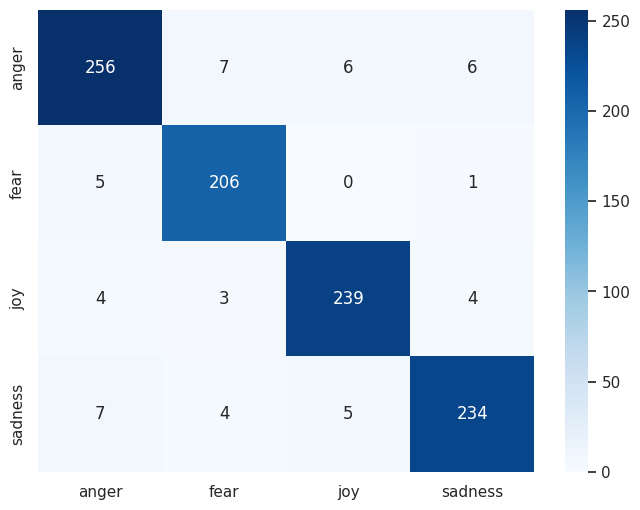

In [38]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger',1: 'fear', 2: 'joy', 3:'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [39]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       275
           1       0.94      0.97      0.95       212
           2       0.96      0.96      0.96       250
           3       0.96      0.94      0.95       250

    accuracy                           0.95       987
   macro avg       0.95      0.95      0.95       987
weighted avg       0.95      0.95      0.95       987



In [40]:
model.save('nlp.h5')
print("Model saved successfully as nlp.h5")

Model saved successfully as nlp.h5


In [41]:
from tensorflow.keras.models import load_model

# upload train model
model = load_model('nlp.h5')

In [42]:
def prediction(model , text):
    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predict = model.predict(x_new)

    emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
    labels = list(emotions.values())

    probs = list(predict[0])

    pred = labels[np.argmax(probs)]
    
    print(f"The Predict is : {pred}")

    plt.figure(figsize=(8,5))
    bars = plt.bar(labels, probs, color='skyblue')

    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f"{prob:.2f}", ha='center', fontsize=12)
    plt.ylabel('Probability')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
The Predict is : joy


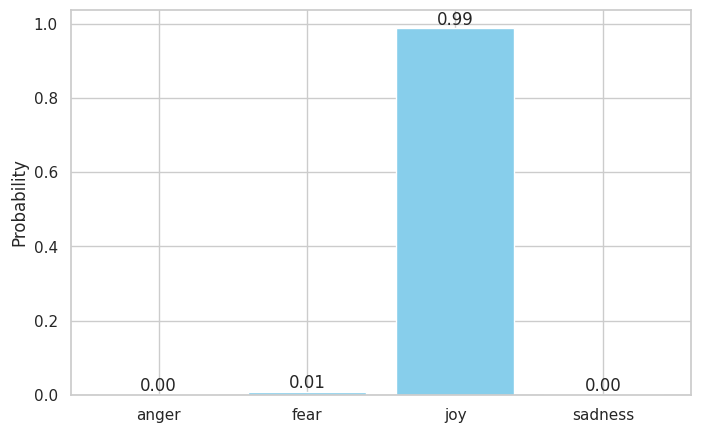

In [43]:
txt = 'I am very happy to finish this project'
prediction(model,txt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
The Predict is : joy


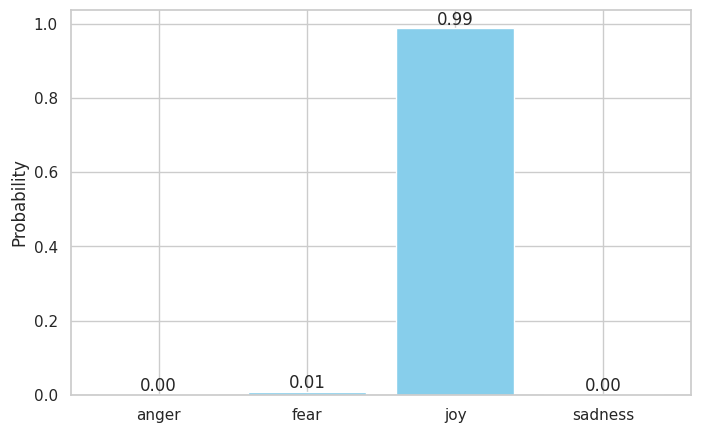

In [44]:
txt = 'I am very happy to finish this project'
prediction(model,txt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
The Predict is : sadness


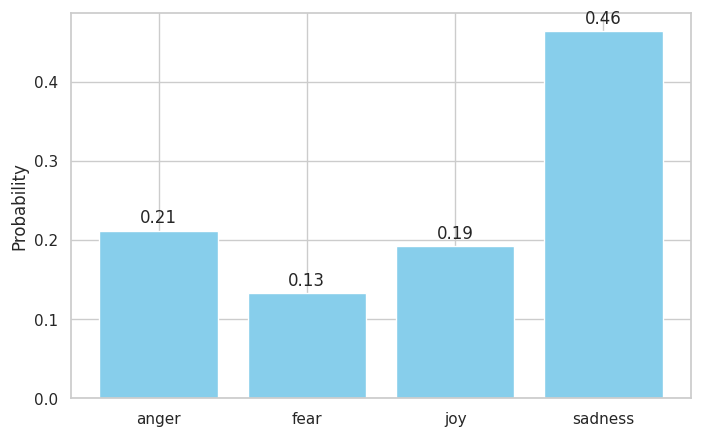

In [45]:
txt = 'I am very sad'
prediction(model,txt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
The Predict is : fear


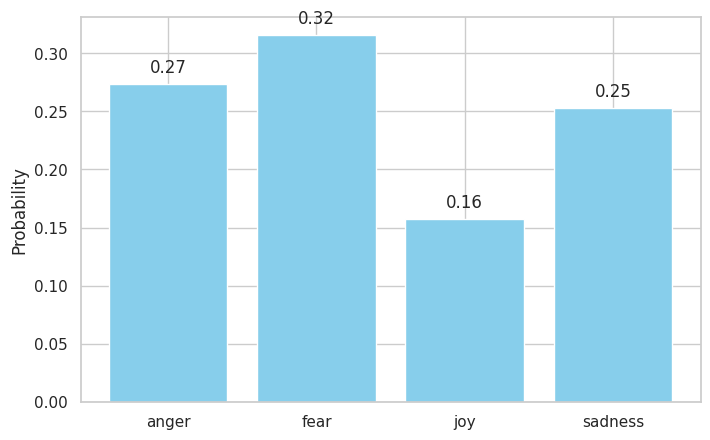

In [46]:
txt = 'Ahhhhhhhhhhhh, I wanna kill myself.'
prediction(model,txt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The Predict is : fear


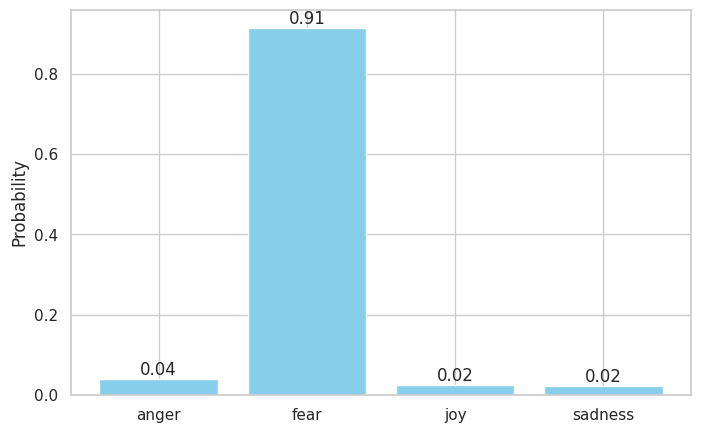

In [47]:
txt = 'I think, i am afraid.'
prediction(model,txt)